In [1]:
import math

import pandas as pd

df = pd.read_csv("nagalmtijden.csv", delimiter=",")

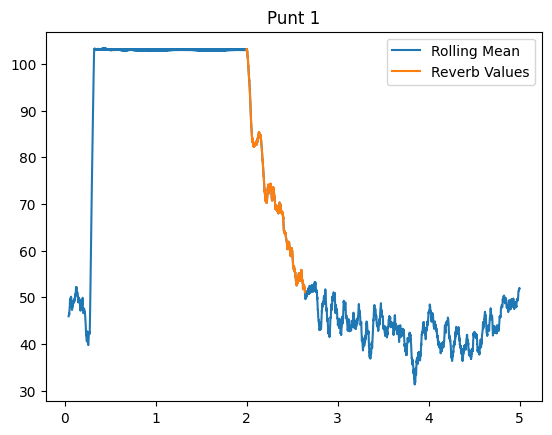

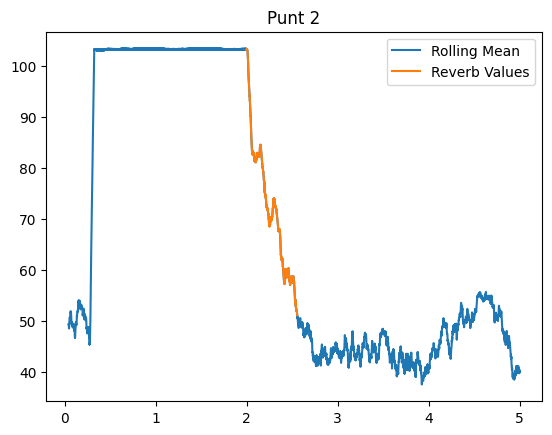

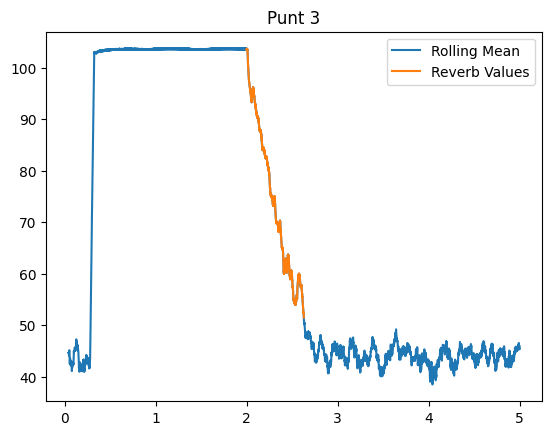

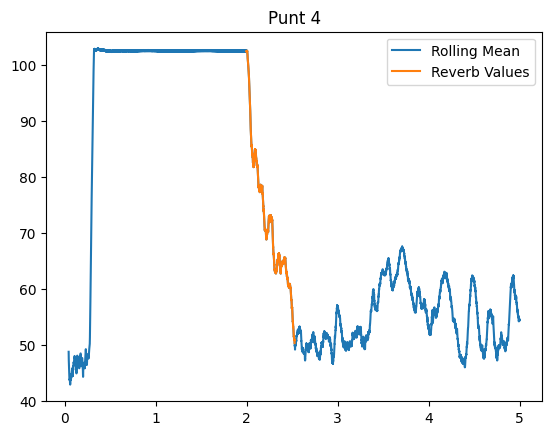

In [3]:
import matplotlib.pyplot as plt

sound_stop_index = 2 * 44100

def rolling_mean(decibels):
    return decibels.rolling(window=2000).mean()

def get_reverb_time(df):
    # Rolling mean of dB array
    _decibel_array = rolling_mean(df['Decibels'])
    _time_stamps = df['Time']
    # Find the maximum sound level in the decibel array
    sound_level_before_drop = _decibel_array[sound_stop_index]

    # Find the index of the first data point where the sound level is 60 dB below the maximum sound level
    _decay_point_index = np.argmax((_decibel_array <= sound_level_before_drop - 52) & (_time_stamps > _time_stamps[sound_stop_index]))

    # Calculate the time it takes for the sound level to decay by 60 dB
    _reverb_time = _time_stamps[_decay_point_index] - _time_stamps[sound_stop_index]

    return _reverb_time, _decay_point_index

reverb_time_point_1, decay_point_index_point_1 = get_reverb_time(df_punt_1)
reverb_time_point_2, decay_point_index_point_2 = get_reverb_time(df_punt_2)
reverb_time_point_3, decay_point_index_point_3 = get_reverb_time(df_punt_3)
reverb_time_point_4, decay_point_index_point_4 = get_reverb_time(df_punt_4)

reverb_values = [[df_punt_1, reverb_time_point_1, decay_point_index_point_1], [df_punt_2, reverb_time_point_2, decay_point_index_point_2], [df_punt_3, reverb_time_point_3, decay_point_index_point_3], [df_punt_4, reverb_time_point_4, decay_point_index_point_4]]

for i in range(len(reverb_values)):
    df = reverb_values[i][0]
    reverb_time = reverb_values[i][1]
    decay_point_index = reverb_values[i][2]

    plt.plot(df['Time'], rolling_mean(df['Decibels']), label='Rolling Mean')

    # Select the rows in the DataFrame that fall within the time range
    time_range_data = df.loc[(df['Time'].index >= sound_stop_index) & (df['Time'].index <= decay_point_index)]

    # Extract the time and decibel values into separate arrays
    time_range_times = time_range_data['Time'].values
    time_range_decibels = time_range_data['Rolling Mean'].values

    plt.plot(time_range_times, time_range_decibels, label='Reverb Values')
    plt.title('Punt ' + str(i+1))
    plt.legend()
    plt.show()

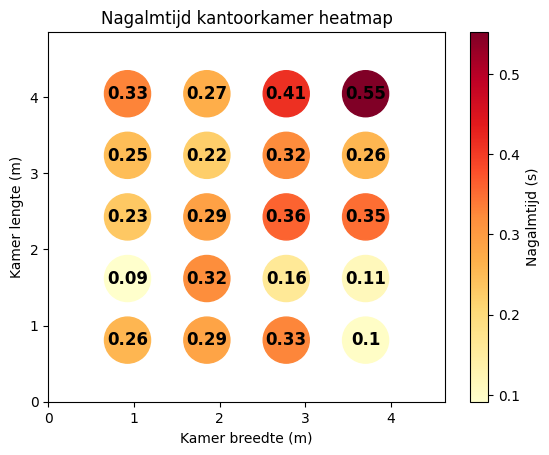

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

df = pd.read_csv("nagalmtijden.csv", delimiter=",")

# Define the dimensions of the room
room_length = 4.85 # in meters
room_width = 4.63 # in meters

def average_results():
    # Create an empty list to store the results
    results = []

    # Loop through the unique values in the "punten" column
    for punten in df['punten'].unique():
        # Select the rows where "punten" equals the current value
        mask = df['punten'] == punten
        rows = df[mask]

        # Calculate the average of the "nagalmtijd" column for those rows
        nagalmtijd_avg = rows['nagalmtijd'].mean()

        # Add the results to the list
        results.append({'punten': punten, 'average_nagalmtijd': nagalmtijd_avg})

    return pd.DataFrame(results)


df = average_results()

def calculate_point_positions():
    amount_of_white_spaces_width = 5
    amount_of_white_spaces_length = 6

    amount_of_points_width = 4

    x_step_size = room_width / amount_of_white_spaces_width
    y_step_size = room_length / amount_of_white_spaces_length

    positions = [[-1, -1] for _ in range(len(df.index))]
    for index, row in df.iterrows():
        punt = row['punten']

        columnIndex = punt % amount_of_points_width
        if columnIndex == 0:
            columnIndex = 4
        x = columnIndex * x_step_size

        rowIndex = math.ceil(punt / amount_of_points_width)
        y = rowIndex * y_step_size

        positions[index] = [punt, x, y]
    return positions

# Define the X-axis values for the heatmap
positions = calculate_point_positions()
x_positions = [inner_list[1] for inner_list in positions]
y_positions = [inner_list[2] for inner_list in positions]

# Define the values for the heatmap
# In this example, the values represent temperature at each point in the room
heatmap_values = df['average_nagalmtijd']

# Create the heatmap using Matplotlib's scatter() function
fig, ax = plt.subplots()
im = ax.scatter(x_positions, y_positions, c=heatmap_values, cmap='YlOrRd', s=1100)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Nagalmtijd (s)')

# Set the X and Y axis labels for the heatmap
ax.set_xlabel('Kamer breedte (m)')
ax.set_ylabel('Kamer lengte (m)')

# Room limits
ax.set_xlim(0, room_width)
ax.set_ylim(0, room_length)

# Set the title of the heatmap
ax.set_title("Nagalmtijd kantoorkamer heatmap")

# Add text annotations for each point
for i, value in enumerate(heatmap_values):
    ax.text(x_positions[i], y_positions[i], round(value, 2),
            ha='center', va='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()
